# Initial Case Study: Collecting the Data for CAPM
The CAPM (the "Capital Asset Pricing Model") attempts to describe the return of a stock $R_i$ in terms of the a risk free return $R_f$, a "market" return $R_m$, and a sensitivity $\beta_i$ to the excess return:

### $$E(R_i)=R_f+\beta_i(E(R_m)-R_f)$$

Let's start out by collecting some data that will be used later to try to calculate the beta of the stock vs the $E(R_m)-R_f$ from real data. Let's start by getting the data for a stock and the "market", for which we'll use the SPY ETF which tracks the S&P 500.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import getstock as gs
import pandas as pd

apikey = "B0LGKLAGCAQEQ2T1"

In [2]:
# SPY is an ETF that tracks the S&P 500, which will be our market proxy
market_prices = gs.getDailyStockPrices("SPY", apikey)

Let's get T-bill rates. I grabbed some from [treasury.gov](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billrates).

In [3]:
# the raw data has a top header row. We want the first column (4 week)
tbill_data = pd.read_excel('../Data/tbilldata.xlsx', skiprows=1)
tbill_data.head()
tbill_data.index = pd.to_datetime(tbill_data['DATE'])
tbill_data = tbill_data.drop('DATE', axis=1)

In [4]:
tbill_data.head()

,BANK DISCOUNT,COUPON EQUIVALENT,BANK DISCOUNT.1,COUPON EQUIVALENT.1,BANK DISCOUNT.2,COUPON EQUIVALENT.2,BANK DISCOUNT.3,COUPON EQUIVALENT.3,BANK DISCOUNT.4,COUPON EQUIVALENT.4
DATE,,,,,,,,,,
2002-01-02,1.71,1.74,NaN,NaN,1.71,1.74,1.81,1.85,NaN,NaN
2002-01-03,1.70,1.73,NaN,NaN,1.70,1.73,1.78,1.82,NaN,NaN
2002-01-04,1.69,1.72,NaN,NaN,1.69,1.72,1.78,1.82,NaN,NaN
2002-01-07,1.68,1.71,NaN,NaN,1.66,1.69,1.73,1.77,NaN,NaN
2002-01-08,1.67,1.69,NaN,NaN,1.65,1.68,1.74,1.78,NaN,NaN


In [5]:
# convert to daily from annualized (360 day) rate in the file
risk_free_daily = tbill_data['BANK DISCOUNT'] / 360

In [6]:
risk_free_daily.head()

DATE
2002-01-02    0.004750
2002-01-03    0.004722
2002-01-04    0.004694
2002-01-07    0.004667
2002-01-08    0.004639
Name: BANK DISCOUNT, dtype: float64

In [7]:
# and let's pick a stock
stock = "TSLA"
stock_prices = gs.getDailyStockPrices(stock, apikey)

In [8]:
# our market data goes back further than our stock data...
market_prices.head()

,open,high,low,close,adjusted_close,volume,dividend_amt,split_coef
2000-04-03,150.1250,151.2500,148.6875,151.2500,103.5817,8508200,0.0,1.0
2000-04-04,151.7500,153.0000,141.3906,150.1250,102.8113,19585500,0.0,1.0
2000-04-05,147.8750,150.8125,147.6250,149.1875,102.1692,8387200,0.0,1.0
2000-04-06,150.2500,151.6875,149.0000,150.4843,103.0573,6378500,0.0,1.0
2000-04-07,151.5625,152.1250,150.5000,151.4375,103.7101,6023600,0.0,1.0


In [9]:
stock_prices.head()

,open,high,low,close,adjusted_close,volume,dividend_amt,split_coef
2010-06-29,19.00,25.0000,17.54,23.89,23.89,18766300,0.0,1.0
2010-06-30,25.79,30.4192,23.30,23.83,23.83,17187100,0.0,1.0
2010-07-01,25.00,25.9200,20.27,21.96,21.96,8218800,0.0,1.0
2010-07-02,23.00,23.1000,18.71,19.20,19.20,5139800,0.0,1.0
2010-07-06,20.00,20.0000,15.83,16.11,16.11,6866900,0.0,1.0


Let's make a single DataFrame of our market, risk free rate and stock return

In [10]:
# let's trim the market data to match and put them both in a single data frame. We'll use open.
start_date = stock_prices.iloc[0].name
model_data = pd.DataFrame(columns=['market_price', 'stock_price'], index=stock_prices.index)
model_data['market_price'] = market_prices[start_date:]
model_data['stock_price'] = stock_prices[start_date:] # just to be safe

In [11]:
# but we want returns, so let's calculate them
model_data['market_ret'] = model_data['market_price'].pct_change()
model_data['stock_ret'] = model_data['stock_price'].pct_change()

In [12]:
# add the risk free rate to our dataframe
model_data['r_f'] = risk_free_daily[start_date:]

In [13]:
model_data

,market_price,stock_price,market_ret,stock_ret,r_f
2010-06-29,106.02,19.00,NaN,NaN,0.000250
2010-06-30,103.92,25.79,-0.019808,0.357368,0.000472
2010-07-01,103.15,25.00,-0.007410,-0.030632,0.000444
2010-07-02,103.11,23.00,-0.000388,-0.080000,0.000444
2010-07-06,103.64,20.00,0.005140,-0.130435,0.000472
...,...,...,...,...,...
2020-03-30,255.70,510.26,0.009595,0.010416,NaN
2020-03-31,260.56,501.25,0.019007,-0.017658,NaN
2020-04-01,247.98,504.00,-0.048281,0.005486,NaN
2020-04-02,245.19,481.03,-0.011251,-0.045575,NaN


### Next stop, analysis

Now we have some data to work with for the next lecture. We'll stop here, but for fun let's plot our returns...

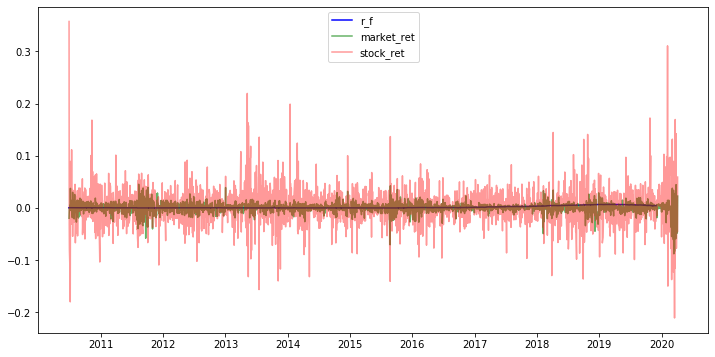

In [14]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(model_data.r_f, color="blue", label="r_f")
ax.plot(model_data.market_ret, color="green", label="market_ret", alpha=0.6)
ax.plot(model_data.stock_ret, color="red", label="stock_ret", alpha=0.4)
plt.legend()
plt.show()